# Unsupervised Language Learning Lab 1

Tom Scheffers - 11728191 <br>
Stefan Knegt - 11784261

In [142]:
import numpy as np
import scipy
import scipy.stats
import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import time

## 2. Getting the pre-trained word vectors

In [36]:
bow2 = {}
with open('bow2.words') as f:
    header = 1
    for line in f:
        if header == 1:
            header = 0
        else:
            word = line.split(' ', 1)[0]
            emb = line.split(' ', 1)[1]
            bow2[word] = emb
            
bow5 = {}
with open('bow5.words') as f:
    header = 1
    for line in f:
        if header == 1:
            header = 0
        else:
            word = line.split(' ', 1)[0]
            emb = line.split(' ', 1)[1]
            bow5[word] = emb
            
dep = {}
with open('deps.words') as f:
    header = 1
    for line in f:
        if header == 1:
            header = 0
        else:
            word = line.split(' ', 1)[0]
            emb = line.split(' ', 1)[1]
            dep[word] = emb
            
for key,value in bow2.items():
    temp_list = value.split()
    temp_list_float = [float(i) for i in temp_list]
    bow2[key] = temp_list_float
    
for key,value in bow5.items():
    temp_list = value.split()
    temp_list_float = [float(i) for i in temp_list]
    bow5[key] = temp_list_float
    
for key,value in dep.items():
    temp_list = value.split()
    temp_list_float = [float(i) for i in temp_list]
    dep[key] = temp_list_float

In [37]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

## 3. Word Similarity Task

In [39]:
simlex_file = './SimLex-999/SimLex-999.txt'
simlex_sim = {}
header = True
with open(simlex_file,'r') as f:
    for line in f:
        if header == True:
            header = False
        else:
            values = line.split('\t')
            simlex_sim[(values[0], values[1])] = float(values[3])

men_file = './MEN/MEN_dataset_natural_form_full'
men_sim = {}
with open(men_file,'r') as g:
    for line in g:
        values = line.split()
        men_sim[(values[0], values[1])] = values[2]


In [67]:
results_spearman = {}
results_pearson = {}


embeddings = {"bow2":bow2,"bow5":bow5,"dep":dep}
sim_dict = {"simlex":simlex_sim,"mensim":men_sim}

spearman_corr = {}
for k1,v1 in embeddings.items():
    for k2,v2 in sim_dict.items():
        list1 = []
        list2 = []
        for key,value in v2.items():
            word1 = key[0]
            word2 = key[1]
            try:
                sim = cos_sim(v1[str(word1)],v1[str(word2)])
                list1.append(float(value))
                list2.append(sim)
            except:
                next
        results_spearman[k1+"-"+k2] = scipy.stats.spearmanr(list1,list2)
        results_pearson[k1+"-"+k2] = scipy.stats.pearsonr(list1,list2)
        
        
    

In [152]:
assert(len(results_pearson)==len(results_spearman))
print(results_pearson)
print(results_spearman)

{'bow5-simlex': (0.37560059706687154, 8.607410572298394e-35), 'bow5-mensim': (0.708236248047157, 0.0), 'bow2-simlex': (0.42845866181644976, 7.992996652237302e-46), 'dep-simlex': (0.46190134429723584, 6.838935662413016e-54), 'dep-mensim': (0.5974016044666726, 1.0183783114137056e-289), 'bow2-mensim': (0.6776982244699228, 0.0)}
{'bow5-simlex': SpearmanrResult(correlation=0.36739613669787896, pvalue=2.9775781067162087e-33), 'bow5-mensim': SpearmanrResult(correlation=0.7231686561368844, pvalue=0.0), 'bow2-simlex': SpearmanrResult(correlation=0.41414576777339385, pvalue=1.226812869252797e-42), 'dep-simlex': SpearmanrResult(correlation=0.4456409349330385, pvalue=7.414295711467014e-50), 'dep-mensim': SpearmanrResult(correlation=0.6178227900207052, pvalue=2.37026036e-315), 'bow2-mensim': SpearmanrResult(correlation=0.699904755830819, pvalue=0.0)}


## 4. Word Analogy Task

In [120]:
analogy_file = 'questions-words.txt'
analogies = []
with open(analogy_file,'r') as h:
    for line in h:
        values = line.split()
        if values[0] != ':':
            analogies.append([values[0], values[1], values[2], values[3]])
print(len(analogies))

19544


In [156]:
analogy_pred = []
start = time.time()
for an in analogies[199:205]:
    a = dep[an[0].lower()]
    a = [(i/sum(a)) for i in a]
    a_star = dep[an[1].lower()]
    a_star = [(i/sum(a_star)) for i in a_star]
    b = dep[an[2].lower()]   
    b = [(i/sum(b)) for i in b]
    b_star = bow2[an[3].lower()]
    b_star = [(i/sum(b_star)) for i in b_star]

    v = [astar_i - a_i for astar_i, a_i in zip(a_star, a)]
    b_pred = [b_i + v_i for b_i, v_i in zip(b, v)]
    pred_scores = []
    words = []
    for key,value in dep.items():
        norm_value = [(i/sum(value)) for i in value]
        score = cos_sim(b_pred,norm_value)
        pred_scores.append(score)
        words.append(key)
    Z = [x for _,x in sorted(zip(pred_scores,words))]
    Z = Z[::-1]
    idx = Z.index(an[3].lower())
    print(an[3].lower())
    print(Z[:10])
    print(idx)
    analogy_pred.append(idx)
print(time.time() - start)      
print(analogy_pred)        

KeyboardInterrupt: 

## 5. Clustering word vectors

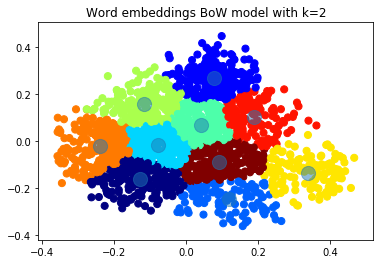

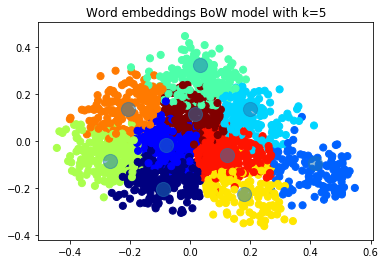

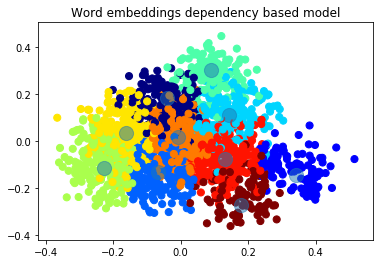

In [101]:
noun_file = '2000_nouns_sorted.txt'
nouns = []
with open(noun_file,'r') as j:
    for word in j:
        nouns.append(str(word.strip(' ').strip('\n')))
        
#Find the word embeddings for the 2000 nouns
X_bow2 = []
X_bow5 = []
X_dep = []
for word in nouns:
    try:
        X_bow2.append(bow2[word])
        X_bow5.append(bow5[word])
        X_dep.append(dep[word])
    except:
        next

#First we apply PCA
pca = PCA(n_components=2)
X_bow2 = pca.fit_transform(X_bow2)
X_bow5 = pca.fit_transform(X_bow5)
X_dep = pca.fit_transform(X_dep)

#Now we cluster the word embeddings that are reduced to 2D using PCA
kmeans_bow2 = KMeans(n_clusters=10,random_state=0).fit(X_bow2)
kmeans_bow5 = KMeans(n_clusters=10,random_state=0).fit(X_bow5)
kmeans_dep = KMeans(n_clusters=10,random_state=0).fit(X_dep)

kmeans_predictions_bow2 = kmeans_bow2.predict(X_bow2)
kmeans_predictions_bow5 = kmeans_bow5.predict(X_bow5)
kmeans_predictions_dep = kmeans_dep.predict(X_dep)

#Plot the results of the Kmeans algorithm (source: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)
plt.scatter(X_bow2[:, 0], X[:, 1], c=kmeans_predictions_bow2, s=50, cmap='jet')
centers_bow2 = kmeans_bow2.cluster_centers_
plt.scatter(centers_bow2[:, 0], centers_bow2[:, 1], s=200, alpha=0.5)
plt.title("Word embeddings BoW model with k=2")
plt.show()

plt.scatter(X_bow5[:, 0], X[:, 1], c=kmeans_predictions_bow5, s=50, cmap='jet')
centers_bow5 = kmeans_bow5.cluster_centers_
plt.scatter(centers_bow5[:, 0], centers_bow5[:, 1], s=200, alpha=0.5)
plt.title("Word embeddings BoW model with k=5")
plt.show()

plt.scatter(X_dep[:, 0], X[:, 1], c=kmeans_predictions_dep, s=50, cmap='jet')
centers_dep = kmeans_dep.cluster_centers_
plt.scatter(centers_dep[:, 0], centers_dep[:, 1], s=200, alpha=0.5)
plt.title("Word embeddings dependency based model")
plt.show()
